<a href="https://colab.research.google.com/github/CarlosBurgosB/Projects/blob/main/Decision_Tree_Model_for_Videogame_Itemization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Model for Videogame Itemization 

The objective of the following code is showing how the choice of an item when there is uncertainty present (e.g, aiming abilities) can be modeled through decision trees.

The player is playing Sylas, a character with 2 skillshots. There are 2 possible items to choose from: Luden's tempest and Everfrost.

* Luden's Tempest: doesn't have an active, it only gives the player more damage.
* Everfrost: gives less stats than Luden's Tempest, but can be activated to unleash icy shards in a cone, rooting enemies in the middle and slowing the ones on the edges.

**TLDR**: Two child nodes, one for each item, there are cases for each item where abilities are hit or missed with known probability. The expected value of the damage is calculated for each node. The item with the most expected damage is the "winner" of the tree.

Results in section **Resulting Tree** (execute previous cells).


## Estructure of the Tree  



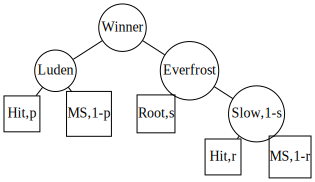

In [5]:
!pip install ipython
!pip install Graphviz
!pip install aed-utilities
import aed_utilities as aed
#Implementing Binary Tree Class
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
    def postorden(self):
        self.izq.postorden()   
        self.der.postorden()
        print(self.info, end=" ")

class Nodoe:
    def __init__(self, info=""):
        self.info=info
    def postorden(self):
        print(self.info, end=" ")

class Arbol:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz        
    def postorden(self):
        print("Postorden:", end=" ")
        self.raiz.postorden()
        print()
    def dibujar(self):
      btd = aed.BinaryTreeDrawer(fieldData="info", fieldLeft="izq", fieldRight="der",classNone=Nodoe )
      btd.draw_tree(self, "raiz")
#The letter is the probability of the event happening
formula= Arbol(
            Nodoi(
                Nodoi(Nodoe("Hit,p"),"Luden",Nodoe("MS,1-p")),
                "Winner",
                Nodoi(
                    Nodoe("Root,s"),
                    "Everfrost",
                    Nodoi(Nodoe("Hit,r"),"Slow,1-s",Nodoe("MS,1-r"))
                )
            )
        )
formula.dibujar()


The decision Tree has two child nodes that represent the item chosen, for each item there are cases where the player miss or hit abilities, each one with a deterministic probability.

There are 2 possibilities for each item:


*   Luden:
   *   Hitting all the spells, with probability p = 30%
   *   Missing some spells, with probability 1-p = 70%

*   Everfrost:
   *   Hitting the root, with probability s = 30%
   *   Missing the root and hitting the slow, with probability 1-s = 70%

The damage in the hit and root case is a full combo.
In the missing some spells case the excpected value of the damage is calculated differently depending on the item:

*   Luden:
   *   With a probability of 1/3, the player misses every skillshot, hitting only passive and w.
   *   With a probability of 1/3, the player misses q, but hits e.
   *   With a probability of 1/3, the player misses e, but hits q.

*   Everfrost:
   *   With a probability of 2/10, the player misses every skillshot, hitting only passive and w (targeted abilities).
   *   With a probability of 4/10, the player misses q, but hits e.
   *   With a probability of 4/10, the player misses e, but hits q.

The Damage building Everfrost is reduced a 26% because of the magic resistance an average character has at lvl 9. While the damage building Luden's Tempest is only reduced a 23%.

To decide which item is the best the expected value for each node is calculated, taking in account the stats of each item.


## Coding the damage of the abilities based on the stats of the chosen item.

In [6]:
#Damage Stats of the items
#Everfrost
E_ap = 80
E_active = 100 + E_ap*(30/100) 
e_multiplier = 100/(100+34.5)
#Luden's Echo
L_ap = 80
L_mr_pen = 6
L_echo = 100 + L_ap*(10/100)
L_multiplier = 100/(100+34.5-L_mr_pen) 
#Abilities Damage Everfrost
Q_efirst = 95
Q_eexp = 204
W_ed = 289
E_e = 168
epassive_proc = 128
#Abilities Damage Luden's
Q_lfirst = 99
Q_lexp = 213
W_ld = 298
E_l = 178
lpassive_proc = 130


In [7]:
#Luden's Ability damage and base cases
LHit_Damage = int((Q_lfirst + Q_lexp + W_ld + E_l + 4*lpassive_proc + L_echo)*L_multiplier)
LMissing_everything = W_ld + 3*lpassive_proc
LMiss_q_hit_e = W_ld + E_l + 3*lpassive_proc
LMiss_e_hit_q = W_ld + Q_lfirst + Q_lexp
LMS_expectedvalue =  int((LMissing_everything * 1/3 + LMiss_q_hit_e * 1/3 + LMiss_e_hit_q * 1/3 + L_echo)*L_multiplier)

#Everfrost's aility Damage and base cases
EHit_Damage =  int((Q_efirst + Q_eexp + W_ed + E_e + 4*epassive_proc + E_active)*e_multiplier)
EMissing_everything = W_ed + 3*epassive_proc
EMiss_q_hit_e = W_ed + E_e + 3*epassive_proc
EMiss_e_hit_q = W_ed + Q_efirst + Q_eexp
EMS_expectedvalue = int((EMissing_everything * 0.2 + EMiss_q_hit_e * 0.4 + EMiss_e_hit_q * 0.4 + E_active)*e_multiplier)

#expected value for the cases
Slow = EHit_Damage*0.5 + EMS_expectedvalue*0.5
Everfrost = EHit_Damage*0.3 + Slow*0.7
Luden = LHit_Damage*0.3 + LMS_expectedvalue*0.7
Winner = 0
if Luden>Everfrost:
  Winner = "Luden"
else:
  Winner = "Everfrost"

## Resulting Tree

This is the resulting tree after computing the data as [expected damage, probability of event], and chossing the item with the most expected damage.

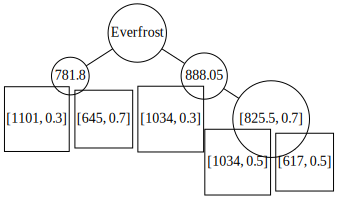

In [8]:
formula= Arbol(
            Nodoi(
                Nodoi(Nodoe([LHit_Damage,0.3]),Luden,Nodoe([LMS_expectedvalue,0.7])),
                Winner,
                Nodoi(
                    Nodoe([EHit_Damage,0.3]),
                    Everfrost,
                    Nodoi(Nodoe([EHit_Damage,0.5]),[Slow,0.7],Nodoe([EMS_expectedvalue,0.5]))
                )
            )
        )
formula.dibujar()

The previous model can be expanded to optimize the choice of multiple actives vs non-active items taking in account the full build of the player and effects of each of the other items built.